In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')

# Step 1: Load the dataset
data = pd.read_excel('/kaggle/input/xgboostregressor/Data for Item Proposal_Regional-1.xlsx', sheet_name="Raw Data")

# Clean column names
data.columns = data.columns.str.replace(' ', "_")

# Preprocess: Handle 'Month' column if it's datetime
if pd.api.types.is_datetime64_any_dtype(data['Month']):
    data['Month_Number'] = pd.to_datetime(data['Month']).dt.month
    data['Year'] = pd.to_datetime(data['Month']).dt.year
    data = data.drop('Month', axis=1)
else:
    print("Month is not datetime, treating as categorical")

# Features and target
X = data.drop(['Net_Sales', 'Item_Name', 'Item_Code'], axis=1)
y = data['Net_Sales']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical Features: {categorical_cols}")
print(f"Numerical Features: {numerical_cols}")

# Step 2: Encode Categorical Variables using LabelEncoder (XGBoost requires numerical input)
X_encoded = X.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le  # Save encoders for potential inverse transform

print("\nCategorical variables encoded successfully.")



Categorical Features: ['Zone_Name', 'Depot', 'Category']
Numerical Features: ['Unit_Price', 'Sales', 'Sales_Qty', 'Net_Discount', 'Month_Number', 'Year']

Categorical variables encoded successfully.


In [25]:
# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, shuffle=True
)

# Step 4: Model Training with XGBoost
print("\nTraining XGBoost Regressor...")
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    eval_metric='mae',
    random_state=42,
    verbosity=1
)

# Fit model
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=50,
    verbose=100
)


Training XGBoost Regressor...
[0]	validation_0-mae:27337.53896	validation_1-mae:28032.15483
[100]	validation_0-mae:274.31011	validation_1-mae:843.30929
[200]	validation_0-mae:160.41114	validation_1-mae:785.24095
[300]	validation_0-mae:115.15323	validation_1-mae:761.43094
[400]	validation_0-mae:92.15855	validation_1-mae:749.89209
[499]	validation_0-mae:79.56293	validation_1-mae:741.92370


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [26]:
# Step 4: Predictions
predictions = model.predict(X_test)


In [27]:
# Step 5: Evaluation Metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / (y_test + 1e-8))) * 100  # Avoid division by zero

# Adjusted R²
n = len(y_test)
p = X_train.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [28]:
print("\n=== Model Performance Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


=== Model Performance Metrics ===
Mean Absolute Error (MAE): 741.37
Mean Squared Error (MSE): 50,499,057.05
Root Mean Squared Error (RMSE): 7,106.27
R² Score: 0.9919
Adjusted R²: 0.9919
Mean Absolute Percentage Error (MAPE): 0.84%


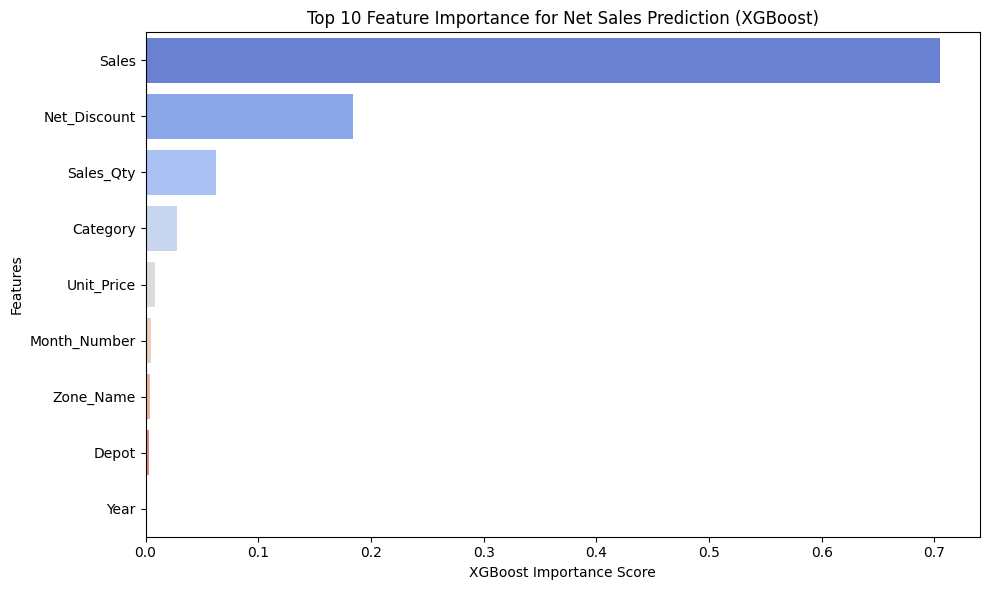

In [32]:
# Feature Importance Plot
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_  # <-- Fixed: Use .feature_importances_
})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.title('Top 10 Feature Importance for Net Sales Prediction (XGBoost)')
plt.xlabel('XGBoost Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

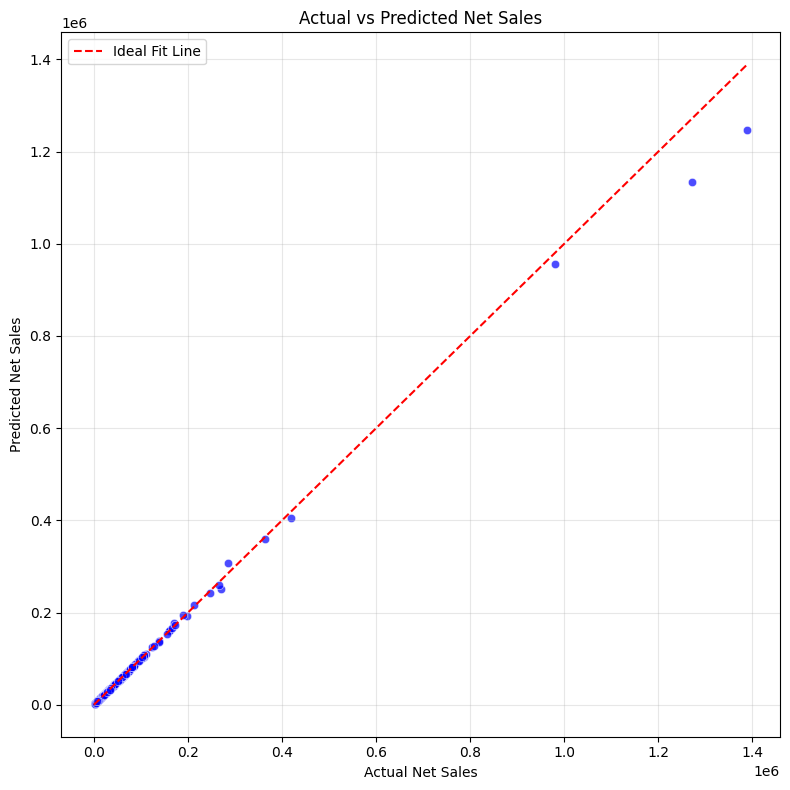

In [34]:
# 2. Actual vs. Predicted Sales Plot
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}).sample(500, random_state=42)
max_val = max(comparison_df['Actual'].max(), comparison_df['Predicted'].max())

plt.figure(figsize=(8, 8))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df, color='blue', alpha=0.7)
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal Fit Line')
plt.title('Actual vs Predicted Net Sales')
plt.xlabel('Actual Net Sales')
plt.ylabel('Predicted Net Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

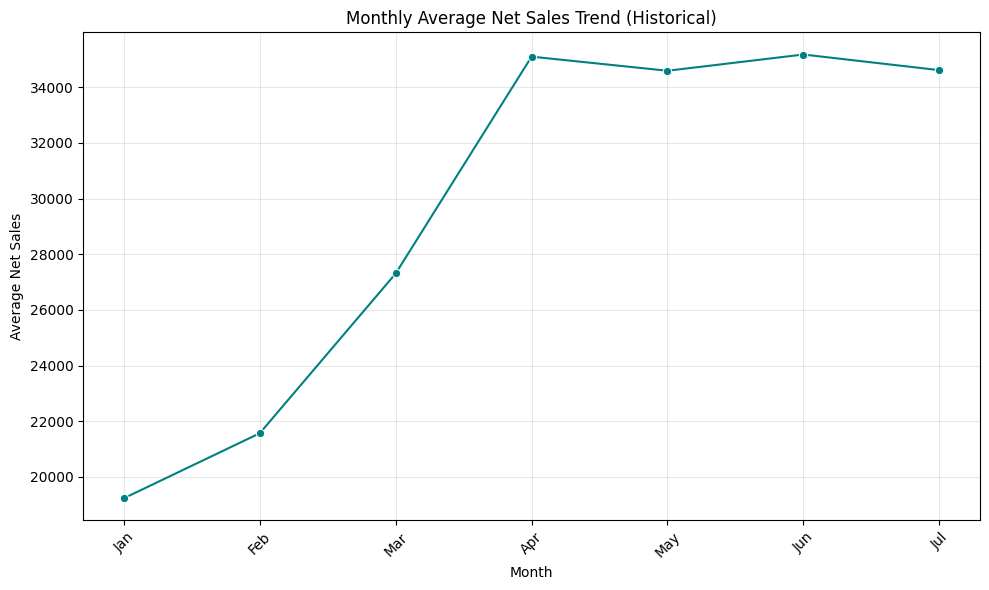

In [35]:
# 3. Monthly Sales Trend Plot (from original data)
if 'Month_Number' in data.columns:
    monthly_sales = data.groupby('Month_Number')['Net_Sales'].mean().reset_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_sales['Month_Name'] = monthly_sales['Month_Number'].map(lambda x: month_names[x-1])

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Month_Name', y='Net_Sales', data=monthly_sales, marker='o', color='teal')
    plt.title('Monthly Average Net Sales Trend (Historical)')
    plt.xlabel('Month')
    plt.ylabel('Average Net Sales')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [36]:
# --- Error Analysis ---

# Calculate errors
errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Absolute_Error': np.abs(y_test - predictions),
    'Percentage_Error': np.abs((y_test - predictions) / (y_test + 1e-8)) * 100
})


In [37]:
# Option 1: Filter by absolute error threshold
threshold = np.percentile(y_test, 75) * 0.1  # e.g., 10% of 75th percentile of sales
large_deviations = errors[errors['Absolute_Error'] > threshold]
print(f"\nData points with Absolute Error > {threshold:.2f}:")
print(large_deviations.sort_values(by='Absolute_Error', ascending=False).head(10))

# Option 2: Top 5% largest errors
error_95th = errors['Absolute_Error'].quantile(0.95)
top_5_percent_errors = errors[errors['Absolute_Error'] > error_95th]
print(f"\nTop 5% Deviated Data Points (Absolute Error > {error_95th:.2f}):")
print(top_5_percent_errors.sort_values(by='Absolute_Error', ascending=False).head(10))

# Optional: Merge with test features for context
X_test_with_errors = X_test.copy()
X_test_with_errors.reset_index(drop=True, inplace=True)
errors_with_features = pd.concat([errors, X_test_with_errors], axis=1)
print("\nTop Deviated Predictions with Feature Context:")
print(errors_with_features.loc[errors_with_features['Absolute_Error'] > error_95th] \
      .sort_values('Absolute_Error', ascending=False)[['Actual', 'Predicted', 'Absolute_Error', 'Zone_Name', 'Depot', 'Unit_Price', 'Sales_Qty']])





Data points with Absolute Error > 2604.00:
          Actual     Predicted  Absolute_Error  Percentage_Error
12445   793872.0  6.400358e+05    153836.25000         19.377966
7753   1389197.0  1.245709e+06    143487.75000         10.328827
9034   1272384.0  1.133185e+06    139198.87500         10.940005
7746   1148198.0  1.011545e+06    136652.62500         11.901486
33     1159935.0  1.041279e+06    118655.87500         10.229528
8615   1070324.0  9.589061e+05    111417.87500         10.409733
9871    448128.0  5.217708e+05     73642.84375         16.433439
4441    775526.0  7.311884e+05     44337.62500          5.717104
6157   1244160.0  1.207604e+06     36556.37500          2.938237
3955    395280.0  3.598061e+05     35473.87500          8.974366

Top 5% Deviated Data Points (Absolute Error > 1133.70):
          Actual     Predicted  Absolute_Error  Percentage_Error
12445   793872.0  6.400358e+05    153836.25000         19.377966
7753   1389197.0  1.245709e+06    143487.75000        

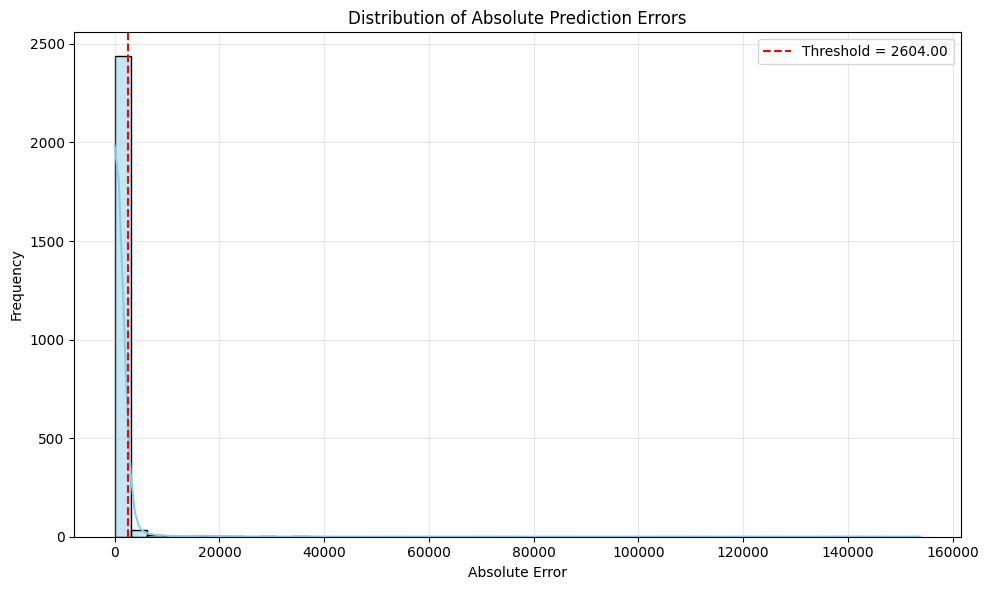

In [38]:
# Histogram of Absolute Errors
plt.figure(figsize=(10, 6))
sns.histplot(errors['Absolute_Error'], bins=50, kde=True, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.title('Distribution of Absolute Prediction Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [39]:
# Step: Percentage of predictions within acceptable error margin
mean_sales = y_test.mean()
acceptable_error = 0.1 * mean_sales  # 10% of average sales
within_range = errors[errors['Absolute_Error'] <= acceptable_error]
accuracy_within_range = (len(within_range) / len(errors)) * 100


In [40]:
print(f"\nAverage Net Sales: {mean_sales:,.2f}")
print(f"Acceptable error threshold (10%): {acceptable_error:,.2f}")
print(f"Number of predictions within ±{acceptable_error:,.2f}: {len(within_range)} out of {len(errors)}")
print(f"Percentage of predictions within acceptable range: {accuracy_within_range:.2f}%")


Average Net Sales: 29,982.98
Acceptable error threshold (10%): 2,998.30
Number of predictions within ±2,998.30: 2435 out of 2505
Percentage of predictions within acceptable range: 97.21%
